In [1]:
import os
import cv2

from helpers.dataset_process import dataset_to_df, search_df

import numpy as np
# import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn

# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
add_extra_epochs = True # if True then continue for extra epochs from the starting epoch
start_from_model = True # If True we will continue training from that a pretrained model

In [4]:
model_state_path = "../../../weights/vit_cifak/checkpoint/"
model_file_name = "vit_patch8_cifak_epoch_263"
checkpoint = torch.load(model_state_path+model_file_name)

In [5]:
img_size = 32  # Input image height/width in pixels
patch_size = 8 # The height/width of a patch in pixels (patch is a slice of an image)

image_patch_flat_size = 3*patch_size**2 #3 Channels x height x width
embed_size = image_patch_flat_size
mlp_dim = 512 # dim of the last mlp classifier

train_batch_size = 512 # https://www.youtube.com/watch?v=Owm1H0ukjS4
valid_batch_size = 512

num_classes = 2
encoder_depth = 6
attention_heads = 12

print(f'Flattened dimension size(of a patch): {image_patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 192
Embedding Size: 192
Output MLP size: 512


In [6]:
n_extra_epochs = 100
max_epochs = 400

start_epoch = checkpoint['epoch'] if start_from_model else 0
end_epoch = start_epoch + n_extra_epochs if add_extra_epochs else max_epochs
delta_epochs = end_epoch-start_epoch

print(f"Train another {delta_epochs} epochs after epoch {start_epoch} ")

Train another 100 epochs after epoch 263 


In [7]:
base_lr = 0.005         # Base Learning rate 0.1 for SGD , 0.001 for Adam
momentum = 0.9          # Momentum for SGD
weight_decay = 0.03     # Weight decay for Adam


loss_algo = CrossEntropyLoss

optimize_algo = SGD  # Adam
optimize_args = {"lr": base_lr,
                 "weight_decay": weight_decay,
                 "momentum": momentum  # comment momentum for Adam
                 }

use_scheduler = True
schedule_algo = CosineAnnealingLR
schedule_args = {"T_max": delta_epochs}

In [8]:
path = '../../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

In [9]:
df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(path, relative_paths, paths_classes, 0.8, 0.19, 0.01)
classes_stats

,REAL,FAKE,Total
Training,48000,48000,96000
Validation,11400,11400,22800
Testing,600,600,1200
Row_Total,60000,60000,120000


In [10]:
print("First and Last Elements in the Whole dataset")
df_all.iloc[[0,-1]]

First and Last Elements in the Whole dataset


,Image_path,Image_size,Class,Class_Codes,Class_Onehot
0,../../../data/CIFAK//train/REAL/0000(10).jpg,"(3, 32, 32)",REAL,1,"[1, 0]"
119999,../../../data/CIFAK//test/FAKE/999.jpg,"(3, 32, 32)",FAKE,0,"[0, 1]"


In [11]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.model(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, emb_dropout = 0., dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [12]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):
        
        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):
        
        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(self.annotation.iloc[index, 3],dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)

        return img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [13]:
norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [14]:
transform_train = transforms.Compose([
    # v2.ToPILImage(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.RandAugment(2, 14),
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAffine(degrees=(0, 180), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    # v2.RandomPerspective(distortion_scale=0.6, p=1.0),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.ToTensor(),
    v2.Normalize(norm_mean, norm_std),
])

transform_valid = transforms.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(norm_mean, norm_std),
])

In [15]:
# Define the dataset object and configure the Data Loader

train_set  = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set  = Images_Dataset(df_val, transform_valid)

valid_loader= DataLoader(dataset=valid_set ,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [16]:
print("Total number of training batches:", len(train_loader))
print("Total number of validation batches:", len(valid_loader))

Total number of training batches: 187
Total number of validation batches: 44


In [17]:
sample_img_batch,label = next(iter(train_loader))

print(f"Batch of Images Shape: {sample_img_batch.size()}")
print(f"Batch of Images Shape: {label.size()}")
print(label)

Batch of Images Shape: torch.Size([512, 3, 32, 32])
Batch of Images Shape: torch.Size([512])
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0

In [18]:
def img_plot(img, slice_width):
    sliced_img = rearrange(
            img, 'c (row h) (col w) -> row col c h w', h=slice_width, w=slice_width)
    print("Sliced Image Shape: ", sliced_img.shape)

    fig = plt.figure(layout="constrained", figsize=(8, 4))
    subfigs = fig.subfigures(3, 1, height_ratios=[1., 1.5, 1.], hspace=0.05, squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    img_a = rearrange(img, "c h w -> h w c").numpy()
    
    axs0.imshow(img_a)
    axs0.axis('off')
    # subfigs[0].suptitle('Input Image', fontsize=10)

    grid1 = ImageGrid(subfigs[1], 111, nrows_ncols=(sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid1):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = rearrange(sliced_img[row][column], "c h w -> h w c").numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[1].suptitle('Slices', fontsize=10)

    grid2 = ImageGrid(subfigs[2], 111, nrows_ncols=(1, sliced_img.size(0)*sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid2):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[2].suptitle('Position', fontsize=10)

Sliced Image Shape:  torch.Size([4, 4, 3, 8, 8])


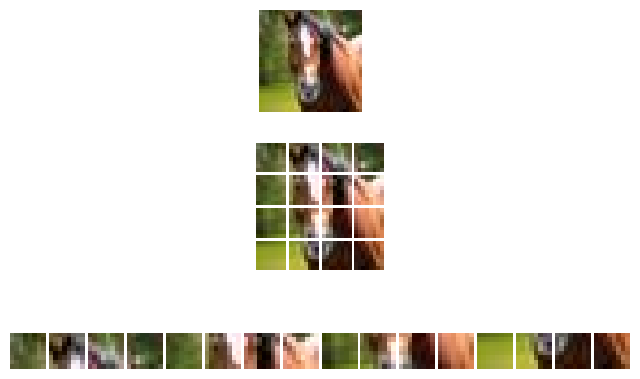

In [19]:
sample_img = read_image(df_train.iloc[100, 0])
img_plot(sample_img, patch_size)

In [20]:
model = ViT(
    image_size=img_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=embed_size,
    depth=encoder_depth,
    heads=attention_heads,
    mlp_dim=mlp_dim,
    emb_dropout=0.1,
    dropout=0.1
)


In [21]:
vit_output = model(sample_img_batch)

print("Input Shape: ", sample_img_batch.size())
print("Output Shape: ", vit_output.size())

summary(model=model,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([512, 3, 32, 32])
Output Shape:  torch.Size([512, 2])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [512, 3, 32, 32]     [512, 2]             3,456                True
├─Sequential (to_patch_embedding)                  [512, 3, 32, 32]     [512, 16, 192]       --                   True
│    └─Rearrange (0)                               [512, 3, 32, 32]     [512, 16, 192]       --                   --
│    └─Linear (1)                                  [512, 16, 192]       [512, 16, 192]       37,056               True
├─Dropout (dropout)                                [512, 17, 192]       [512, 17, 192]       --                   --
├─Transformer (transformer)                        [512, 17, 192]       [512, 17, 192]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─ModuleList (0)                     

In [22]:
criterion = loss_algo()
optimizer = optimize_algo(model.parameters(), **optimize_args)
scheduler = schedule_algo(optimizer, **schedule_args)

In [23]:
if start_from_model:
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    best_acc = checkpoint['best_acc']
    list_tr_loss = checkpoint['list_tr_loss']
    list_tr_acc = checkpoint['list_tr_acc']
    list_val_loss = checkpoint['list_val_loss']
    list_val_acc = checkpoint['list_val_acc']
else:
    best_acc = 0

    list_tr_loss = []
    list_tr_acc = []
    list_val_loss = []
    list_val_acc = []

In [24]:
model.to(device)
for epoch in range(start_epoch, end_epoch):

    print(f'\n epoch: {epoch+1}/{end_epoch}')

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)


        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path (Gradient)
        loss.backward()
        # Optimizer(Adam) Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total

        loop1.set_description(f"Train--Epoch [{epoch+1}/{end_epoch}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    list_tr_loss.append(avg_tr_loss)
    list_tr_acc.append(avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{end_epoch}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)

    list_val_loss.append(avg_val_loss)
    list_val_acc.append(avg_val_accuracy)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "epoch": epoch,
                 "best_acc": best_acc,
                 "list_tr_loss": list_tr_loss,
                 "list_tr_acc": list_tr_acc,
                 "list_val_loss": list_val_loss,
                 "list_val_acc": list_val_acc
                 }
        torch.save(state, model_state_path +f'vit_patch{patch_size}_cifak_epoch_{epoch}')

    ##########################################################

    if use_scheduler: scheduler.step()  # step scheduling


 epoch: 264/363


Valid--Epoch [264/363]: 100%|██████████| 44/44 [00:01<00:00, 24.64it/s, acc=59.2, loss=0.675]


 epoch: 265/363



Valid--Epoch [265/363]: 100%|██████████| 44/44 [00:01<00:00, 25.72it/s, acc=59.2, loss=0.675]


 epoch: 266/363



Valid--Epoch [266/363]: 100%|██████████| 44/44 [00:01<00:00, 25.33it/s, acc=59.2, loss=0.675]



 epoch: 267/363


Valid--Epoch [267/363]: 100%|██████████| 44/44 [00:01<00:00, 24.47it/s, acc=59.2, loss=0.675]


 epoch: 268/363



Valid--Epoch [268/363]: 100%|██████████| 44/44 [00:01<00:00, 24.81it/s, acc=59.2, loss=0.675]



 epoch: 269/363


Valid--Epoch [269/363]: 100%|██████████| 44/44 [00:01<00:00, 24.09it/s, acc=59.2, loss=0.675]


 epoch: 270/363



Valid--Epoch [270/363]: 100%|██████████| 44/44 [00:01<00:00, 24.52it/s, acc=59.2, loss=0.675]


 epoch: 271/363



Valid--Epoch [271/363]: 100%|██████████| 44/44 [00:01<00:00, 23.87it/s, acc=59.2, loss=0.675]


 epoch: 272/363



Valid--Epoch [272/363]: 100%|██████████| 44/44 [00:01<00:00, 23.95it/s, acc=59.2, loss=0.675]


 epoch: 273/363



Valid--Epoch [273/363]: 100%|██████████| 44/44 [00:01<00:00, 23.34it/s, acc=59.2, loss=0.675]


 epoch: 274/363



Valid--Epoch [274/363]: 100%|██████████| 44/44 [00:01<00:00, 24.39it/s, acc=59.2, loss=0.675]


 epoch: 275/363



Valid--Epoch [275/363]: 100%|██████████| 44/44 [00:01<00:00, 24.98it/s, acc=59.2, loss=0.675]


 epoch: 276/363



Valid--Epoch [276/363]: 100%|██████████| 44/44 [00:01<00:00, 24.18it/s, acc=59.2, loss=0.675]


 epoch: 277/363



Valid--Epoch [277/363]: 100%|██████████| 44/44 [00:01<00:00, 23.87it/s, acc=59.2, loss=0.675]



 epoch: 278/363


Valid--Epoch [278/363]: 100%|██████████| 44/44 [00:01<00:00, 23.09it/s, acc=59.2, loss=0.675]



 epoch: 279/363


Valid--Epoch [279/363]: 100%|██████████| 44/44 [00:01<00:00, 23.75it/s, acc=59.2, loss=0.675]



 epoch: 280/363


Valid--Epoch [280/363]: 100%|██████████| 44/44 [00:01<00:00, 24.51it/s, acc=59.2, loss=0.675]


 epoch: 281/363



Valid--Epoch [281/363]: 100%|██████████| 44/44 [00:01<00:00, 23.19it/s, acc=59.3, loss=0.675]



 epoch: 282/363


Valid--Epoch [282/363]: 100%|██████████| 44/44 [00:01<00:00, 22.31it/s, acc=59.2, loss=0.675]


 epoch: 283/363



Valid--Epoch [283/363]: 100%|██████████| 44/44 [00:01<00:00, 23.72it/s, acc=59.2, loss=0.675]


 epoch: 284/363



Valid--Epoch [284/363]: 100%|██████████| 44/44 [00:01<00:00, 22.99it/s, acc=59.2, loss=0.675]


 epoch: 285/363



Valid--Epoch [285/363]: 100%|██████████| 44/44 [00:01<00:00, 24.38it/s, acc=59.2, loss=0.675]



 epoch: 286/363


Valid--Epoch [286/363]: 100%|██████████| 44/44 [00:01<00:00, 23.92it/s, acc=59.2, loss=0.675]


 epoch: 287/363



Valid--Epoch [287/363]: 100%|██████████| 44/44 [00:01<00:00, 24.30it/s, acc=59.2, loss=0.675]


 epoch: 288/363



Valid--Epoch [288/363]: 100%|██████████| 44/44 [00:01<00:00, 23.72it/s, acc=59.2, loss=0.675]


 epoch: 289/363



Valid--Epoch [289/363]: 100%|██████████| 44/44 [00:01<00:00, 23.91it/s, acc=59.2, loss=0.675]


 epoch: 290/363



Valid--Epoch [290/363]: 100%|██████████| 44/44 [00:01<00:00, 23.67it/s, acc=59.2, loss=0.675]



 epoch: 291/363


Valid--Epoch [291/363]: 100%|██████████| 44/44 [00:01<00:00, 23.89it/s, acc=59.2, loss=0.675]


 epoch: 292/363



Valid--Epoch [292/363]: 100%|██████████| 44/44 [00:01<00:00, 23.79it/s, acc=59.2, loss=0.675]


 epoch: 293/363



Valid--Epoch [293/363]: 100%|██████████| 44/44 [00:01<00:00, 23.31it/s, acc=59.2, loss=0.675]


 epoch: 294/363



Valid--Epoch [294/363]: 100%|██████████| 44/44 [00:01<00:00, 23.07it/s, acc=59.2, loss=0.675]


 epoch: 295/363



Valid--Epoch [295/363]: 100%|██████████| 44/44 [00:01<00:00, 24.19it/s, acc=59.3, loss=0.675]



 epoch: 296/363


Valid--Epoch [296/363]: 100%|██████████| 44/44 [00:01<00:00, 23.50it/s, acc=59.2, loss=0.675]


 epoch: 297/363



Valid--Epoch [297/363]: 100%|██████████| 44/44 [00:01<00:00, 24.25it/s, acc=59.2, loss=0.675]



 epoch: 298/363


Valid--Epoch [298/363]: 100%|██████████| 44/44 [00:01<00:00, 23.18it/s, acc=59.2, loss=0.675]



 epoch: 299/363


Valid--Epoch [299/363]: 100%|██████████| 44/44 [00:01<00:00, 23.56it/s, acc=59.2, loss=0.675]


 epoch: 300/363



Valid--Epoch [300/363]: 100%|██████████| 44/44 [00:01<00:00, 23.94it/s, acc=59.2, loss=0.675]


 epoch: 301/363



Valid--Epoch [301/363]: 100%|██████████| 44/44 [00:01<00:00, 23.52it/s, acc=59.2, loss=0.675]



 epoch: 302/363


Valid--Epoch [302/363]: 100%|██████████| 44/44 [00:01<00:00, 22.97it/s, acc=59.2, loss=0.675]



 epoch: 303/363


Valid--Epoch [303/363]: 100%|██████████| 44/44 [00:01<00:00, 23.64it/s, acc=59.2, loss=0.675]


 epoch: 304/363



Valid--Epoch [304/363]: 100%|██████████| 44/44 [00:01<00:00, 23.28it/s, acc=59.2, loss=0.675]



 epoch: 305/363


Valid--Epoch [305/363]: 100%|██████████| 44/44 [00:01<00:00, 24.07it/s, acc=59.2, loss=0.675]



 epoch: 306/363


Valid--Epoch [306/363]: 100%|██████████| 44/44 [00:01<00:00, 23.49it/s, acc=59.2, loss=0.675]


 epoch: 307/363



Valid--Epoch [307/363]: 100%|██████████| 44/44 [00:01<00:00, 22.76it/s, acc=59.2, loss=0.675]


 epoch: 308/363



Valid--Epoch [308/363]: 100%|██████████| 44/44 [00:01<00:00, 23.27it/s, acc=59.2, loss=0.675]


 epoch: 309/363



Valid--Epoch [309/363]: 100%|██████████| 44/44 [00:01<00:00, 23.08it/s, acc=59.2, loss=0.675]


 epoch: 310/363



Valid--Epoch [310/363]: 100%|██████████| 44/44 [00:01<00:00, 23.21it/s, acc=59.2, loss=0.675]


 epoch: 311/363



Valid--Epoch [311/363]: 100%|██████████| 44/44 [00:01<00:00, 24.04it/s, acc=59.2, loss=0.675]



 epoch: 312/363


Valid--Epoch [312/363]: 100%|██████████| 44/44 [00:01<00:00, 24.22it/s, acc=59.2, loss=0.675]



 epoch: 313/363


Valid--Epoch [313/363]: 100%|██████████| 44/44 [00:01<00:00, 23.46it/s, acc=59.2, loss=0.675]


 epoch: 314/363



Valid--Epoch [314/363]: 100%|██████████| 44/44 [00:01<00:00, 24.04it/s, acc=59.2, loss=0.675]


 epoch: 315/363



Valid--Epoch [315/363]: 100%|██████████| 44/44 [00:01<00:00, 23.52it/s, acc=59.2, loss=0.675]


 epoch: 316/363



Valid--Epoch [316/363]: 100%|██████████| 44/44 [00:01<00:00, 23.09it/s, acc=59.2, loss=0.675]


 epoch: 317/363



Valid--Epoch [317/363]: 100%|██████████| 44/44 [00:01<00:00, 24.10it/s, acc=59.2, loss=0.675]


 epoch: 318/363



Valid--Epoch [318/363]: 100%|██████████| 44/44 [00:01<00:00, 23.92it/s, acc=59.2, loss=0.675]


 epoch: 319/363



Valid--Epoch [319/363]: 100%|██████████| 44/44 [00:01<00:00, 23.06it/s, acc=59.2, loss=0.675]



 epoch: 320/363


Valid--Epoch [320/363]: 100%|██████████| 44/44 [00:01<00:00, 23.71it/s, acc=59.2, loss=0.675]



 epoch: 321/363


Valid--Epoch [321/363]: 100%|██████████| 44/44 [00:01<00:00, 23.56it/s, acc=59.2, loss=0.675]


 epoch: 322/363



Valid--Epoch [322/363]: 100%|██████████| 44/44 [00:01<00:00, 23.43it/s, acc=59.2, loss=0.675]



 epoch: 323/363


Valid--Epoch [323/363]: 100%|██████████| 44/44 [00:01<00:00, 23.45it/s, acc=59.2, loss=0.675]


 epoch: 324/363



Valid--Epoch [324/363]: 100%|██████████| 44/44 [00:01<00:00, 24.32it/s, acc=59.2, loss=0.675]



 epoch: 325/363


Valid--Epoch [325/363]: 100%|██████████| 44/44 [00:01<00:00, 23.88it/s, acc=59.2, loss=0.675]


 epoch: 326/363



Valid--Epoch [326/363]: 100%|██████████| 44/44 [00:01<00:00, 23.88it/s, acc=59.2, loss=0.675]


 epoch: 327/363



Valid--Epoch [327/363]: 100%|██████████| 44/44 [00:01<00:00, 23.81it/s, acc=59.2, loss=0.675]


 epoch: 328/363



Valid--Epoch [328/363]: 100%|██████████| 44/44 [00:01<00:00, 23.06it/s, acc=59.2, loss=0.675]


 epoch: 329/363



Valid--Epoch [329/363]: 100%|██████████| 44/44 [00:01<00:00, 23.66it/s, acc=59.2, loss=0.675]


 epoch: 330/363



Valid--Epoch [330/363]: 100%|██████████| 44/44 [00:01<00:00, 23.30it/s, acc=59.2, loss=0.675]


 epoch: 331/363



Valid--Epoch [331/363]: 100%|██████████| 44/44 [00:01<00:00, 23.40it/s, acc=59.2, loss=0.675]


 epoch: 332/363



Valid--Epoch [332/363]: 100%|██████████| 44/44 [00:01<00:00, 23.92it/s, acc=59.2, loss=0.675]



 epoch: 333/363


Valid--Epoch [333/363]: 100%|██████████| 44/44 [00:01<00:00, 23.77it/s, acc=59.2, loss=0.675]


 epoch: 334/363



Valid--Epoch [334/363]: 100%|██████████| 44/44 [00:01<00:00, 23.35it/s, acc=59.2, loss=0.675]


 epoch: 335/363



Valid--Epoch [335/363]: 100%|██████████| 44/44 [00:01<00:00, 23.69it/s, acc=59.2, loss=0.675]


 epoch: 336/363



Valid--Epoch [336/363]: 100%|██████████| 44/44 [00:01<00:00, 23.10it/s, acc=59.2, loss=0.675]



 epoch: 337/363


Valid--Epoch [337/363]: 100%|██████████| 44/44 [00:01<00:00, 23.92it/s, acc=59.2, loss=0.675]


 epoch: 338/363



Valid--Epoch [338/363]: 100%|██████████| 44/44 [00:01<00:00, 23.82it/s, acc=59.2, loss=0.675]


 epoch: 339/363



Valid--Epoch [339/363]: 100%|██████████| 44/44 [00:01<00:00, 24.48it/s, acc=59.2, loss=0.675]


 epoch: 340/363



Valid--Epoch [340/363]: 100%|██████████| 44/44 [00:01<00:00, 23.95it/s, acc=59.2, loss=0.675]



 epoch: 341/363


Valid--Epoch [341/363]: 100%|██████████| 44/44 [00:01<00:00, 22.36it/s, acc=59.2, loss=0.675]


 epoch: 342/363



Valid--Epoch [342/363]: 100%|██████████| 44/44 [00:01<00:00, 24.06it/s, acc=59.2, loss=0.675]


 epoch: 343/363



Valid--Epoch [343/363]: 100%|██████████| 44/44 [00:01<00:00, 22.72it/s, acc=59.2, loss=0.675]


 epoch: 344/363



Valid--Epoch [344/363]: 100%|██████████| 44/44 [00:01<00:00, 23.42it/s, acc=59.2, loss=0.675]


 epoch: 345/363



Valid--Epoch [345/363]: 100%|██████████| 44/44 [00:01<00:00, 23.19it/s, acc=59.2, loss=0.675]


 epoch: 346/363



Valid--Epoch [346/363]: 100%|██████████| 44/44 [00:01<00:00, 22.74it/s, acc=59.2, loss=0.675]


 epoch: 347/363



Valid--Epoch [347/363]: 100%|██████████| 44/44 [00:02<00:00, 20.70it/s, acc=59.2, loss=0.675]


 epoch: 348/363



Valid--Epoch [348/363]: 100%|██████████| 44/44 [00:02<00:00, 20.04it/s, acc=59.2, loss=0.675]


 epoch: 349/363



Valid--Epoch [349/363]: 100%|██████████| 44/44 [00:02<00:00, 20.55it/s, acc=59.2, loss=0.675]


 epoch: 350/363



Valid--Epoch [350/363]: 100%|██████████| 44/44 [00:02<00:00, 20.34it/s, acc=59.2, loss=0.675]


 epoch: 351/363



Valid--Epoch [351/363]: 100%|██████████| 44/44 [00:02<00:00, 21.49it/s, acc=59.2, loss=0.675]


 epoch: 352/363



Valid--Epoch [352/363]: 100%|██████████| 44/44 [00:02<00:00, 16.59it/s, acc=59.2, loss=0.675]


 epoch: 353/363



Valid--Epoch [353/363]: 100%|██████████| 44/44 [00:02<00:00, 16.70it/s, acc=59.2, loss=0.675]


 epoch: 354/363



Valid--Epoch [354/363]: 100%|██████████| 44/44 [00:02<00:00, 17.94it/s, acc=59.2, loss=0.675]


 epoch: 355/363



Valid--Epoch [355/363]: 100%|██████████| 44/44 [00:01<00:00, 23.74it/s, acc=59.2, loss=0.675]


 epoch: 356/363



Valid--Epoch [356/363]: 100%|██████████| 44/44 [00:01<00:00, 23.15it/s, acc=59.2, loss=0.675]


 epoch: 357/363



Valid--Epoch [357/363]: 100%|██████████| 44/44 [00:01<00:00, 22.37it/s, acc=59.2, loss=0.675]


 epoch: 358/363



Valid--Epoch [358/363]: 100%|██████████| 44/44 [00:01<00:00, 23.11it/s, acc=59.2, loss=0.675]


 epoch: 359/363



Valid--Epoch [359/363]: 100%|██████████| 44/44 [00:01<00:00, 23.74it/s, acc=59.2, loss=0.675]


 epoch: 360/363



Valid--Epoch [360/363]: 100%|██████████| 44/44 [00:01<00:00, 22.53it/s, acc=59.2, loss=0.675]


 epoch: 361/363



Valid--Epoch [361/363]: 100%|██████████| 44/44 [00:01<00:00, 23.24it/s, acc=59.2, loss=0.675]



 epoch: 362/363


Valid--Epoch [362/363]: 100%|██████████| 44/44 [00:01<00:00, 24.11it/s, acc=59.2, loss=0.675]


 epoch: 363/363



Valid--Epoch [363/363]: 100%|██████████| 44/44 [00:01<00:00, 23.34it/s, acc=59.2, loss=0.675]


In [32]:
print(optimizer)
print(optimizer.state_dict())

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.01
    lr: 0.0
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}, 3: {'momentum_buffer': None}, 4: {'momentum_buffer': None}, 5: {'momentum_buffer': None}, 6: {'momentum_buffer': None}, 7: {'momentum_buffer': None}, 8: {'momentum_buffer': None}, 9: {'momentum_buffer': None}, 10: {'momentum_buffer': None}, 11: {'momentum_buffer': None}, 12: {'momentum_buffer': None}, 13: {'momentum_buffer': None}, 14: {'momentum_buffer': None}, 15: {'momentum_buffer': None}, 16: {'momentum_buffer': None}, 17: {'momentum_buffer': None}, 18: {'momentum_buffer': None}, 19: {'momentum_buffer': None}, 20: {'momentum_buffer': None}, 21: {'momentum_buffer': None}, 22: {'momentum_buffer': None}, 23: {'momentum_buffer': None}, 24: {'momentum_buffer': None}, 25: {'momentum_buffer': None

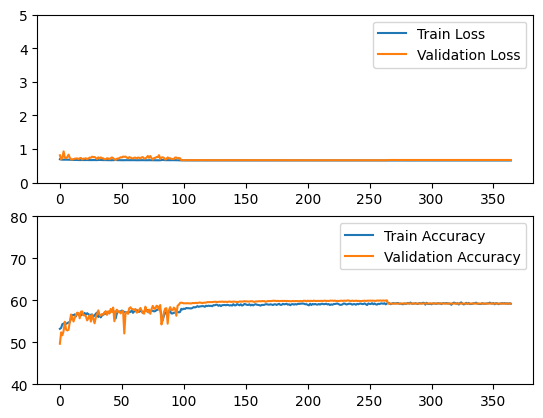

In [25]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(list_tr_loss )), list_tr_loss , label='Train Loss')
axs[0].plot(range(len(list_val_loss)), list_val_loss, label='Validation Loss')
axs[0].set_ylim([0,5])

axs[1].plot(range(len(list_tr_acc)), list_tr_acc, label='Train Accuracy')
axs[1].plot(range(len(list_val_acc)), list_val_acc, label='Validation Accuracy')
axs[1].set_ylim([40,80])

axs[0].legend()
axs[1].legend()
plt.show()